In [1]:
from statistics import median, mean, variance, stdev
from random import gauss, seed, uniform, random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from collections import deque 
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import math

## Генерация равномерного сигнала

In [114]:
N = int(input('Введите длину сигнала: '))
m = int(input('Введите номинальную разладку: '))

In [138]:
def gen(N, m=None):
    '''
    Функция для генерации равномерно распределенной случайной величины c разладкой
    N - общая длина сигнала
    m - номер такта номинальной разладки
    '''
    if m is not None:
        signal_before = [uniform(-1, 1) for _ in range(0, m)] # мат ожидание 0.5
        signal_after = [uniform(0.2, 1.2) for _ in range(m, N)] # мат ожидание 0.7
        return signal_before + signal_after
    else:
        signal = [uniform(0, 1) for _ in range(0, N)]
        return signal


Сгенерируем равномерный сигнал без разладки, который распределен на промежутке от 0 до 1

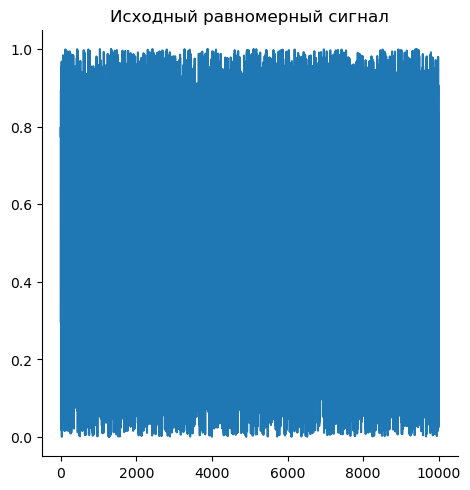

In [216]:
uniform_signal = gen(10000)

plot = sns.relplot(data=uniform_signal, kind='line')
plot.set(xlabel=None, ylabel=None, title='Исходный равномерный сигнал')
plt.show()

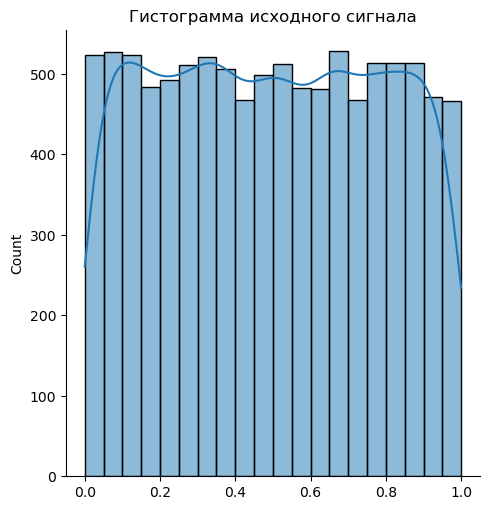

In [217]:
plot = sns.displot(data=uniform_signal, kde=True, bins=20, legend=False)
plot.set(title='Гистограмма исходного сигнала')
plt.show()

## Преобразование Бокса-Мюллера

Преобразуем исходный равномерный сигнал в гауссовский сигнал с разладкой методом бокса-мюллера

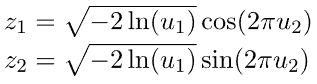

In [218]:
def transform_signal(uniform_signal, N, m=None):

    gaussian_signal = []
    for i in range(0, N, 2):
        
        u1 = uniform_signal[i]
        u2 = uniform_signal[i+1]
        
        r = math.sqrt(-2 * math.log(u1))
        theta = 2 * math.pi * u2
        z1 = r * math.cos(theta)
        z2 = r * math.sin(theta)

        # добавляем математическое ожидание (разладка)
        if m is not None:
            if i >= m:
                z1 += 1 
                z2 += 1

        gaussian_signal.append(z1)
        gaussian_signal.append(z2)
        
    return gaussian_signal

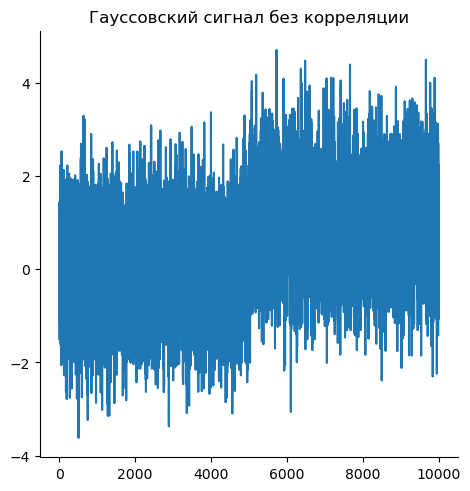

In [219]:
gaussian_signal = transform_signal(uniform_signal, 10000, 5000)

plot = sns.relplot(data=gaussian_signal, kind='line')
plot.set(xlabel=None, ylabel=None, title='Гауссовский сигнал без корреляции')
plt.show()

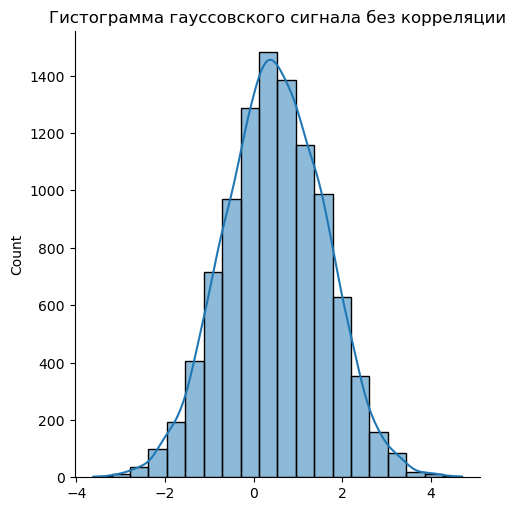

In [220]:
plot = sns.displot(data=gaussian_signal, kde=True, bins=20, legend=False)
plot.set(title='Гистограмма гауссовского сигнала без корреляции')
plt.show()

## Авторегрессия второго порядка

In [226]:
def get_correlation(gaussian_signal, b1, b2):
    
    corr_gaussian_signal = []
    x1 = b1 * 0 + b2 * 0 + gaussian_signal[0]
    x2 = b1 * x1 + b2 * 0 + gaussian_signal[1]
    corr_gaussian_signal.append(x1)
    corr_gaussian_signal.append(x2)

    for i in range(2, len(gaussian_signal)):
        
        e = gaussian_signal[i]
        x = b1 * corr_gaussian_signal[i-1] + b2 * corr_gaussian_signal[i-2] + e
        corr_gaussian_signal.append(x)

    # corr_gaussian_signal = corr_gaussian_signal[2:]
    
    # нормализация
    mn = mean(corr_gaussian_signal)
    std = stdev(corr_gaussian_signal)
    corr_gaussian_signal = ((np.array(corr_gaussian_signal) + mn) / std).tolist()

    return corr_gaussian_signal

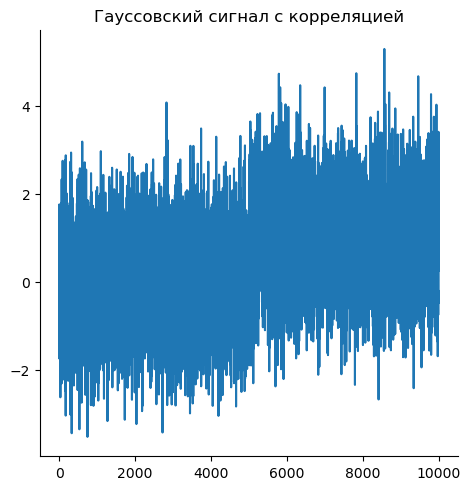

In [225]:
corr_gaussian_signal = get_correlation(gaussian_signal, 0.25, -0.25)

plot = sns.relplot(data=corr_gaussian_signal, kind='line')
plot.set(xlabel=None, ylabel=None, title='Гауссовский сигнал с корреляцией')
plt.show()

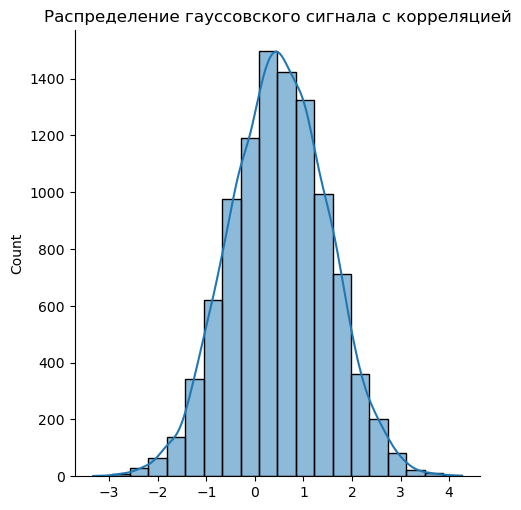

In [150]:
plot = sns.displot(corr_gaussian_signal, kde=True, bins=20, legend=False)
plot.set(title='Распределение гауссовского сигнала с корреляцией')
plt.show()

## Корреляционная функция

In [ ]:
def get_auto_corr(signal, k):

    length = len(signal)
    signal1 = signal[0:length-k]
    signal2 = signal[k:]
    signal_mean = signal.mean()
    signal_var = np.array([i**2 for i in signal-signal_mean]).sum()
    auto_corr = 0
    
    for i in range(length - k):
        temp = (signal1[i] - signal_mean) * (signal2[i] - signal_mean) / signal_var
        auto_corr = auto_corr + temp  

    return auto_corr

def plot_auto_corr(signal, k):
    
    corr_val = []
    for i in range(1, k + 1):
        corr_val.append(get_auto_corr(signal, i))

    # параметр τ мк
    for i in range(k):
        if corr_val[i] < 0.05 and corr_val[i] > -0.05:
            print('τ мк:', i + 1)
            break
    
    plt.figure(figsize=(3, 5))
    plt.bar(range(1, k + 1), corr_val, width = 0.8)
    plt.title("Корреляционная функция")
    plt.show()

plot_auto_corr(np.array(corr_gaussian_signal), 20)

τ мк: 7
τ к: 1.25


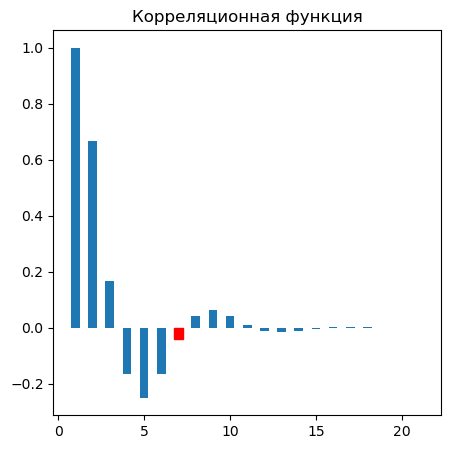

In [70]:
def RF(b1, b2):
    R = []
    for i in range(21):
        if i == 0:
            R.append(1)
        if i == 1:
            R.append(b1 / (1 - b2))
        if i > 1:
            R.append(b1 * R[i - 1] + b2 * R[i - 2])

    return R

R = RF(1, -0.5)

# параметр τ мк
for i in range(len(R)):
    if R[i] < 0.05 and R[i] > -0.05:
        print('τ мк:', i + 1)
        lim = i
        break
# параметр τ к
print('τ к:', round(sum(R[:lim]), 2))

plt.figure(figsize=(5, 5))
barlist = plt.bar(range(1, len(R) + 1), R, width = 0.5)
barlist[lim].set_color('r')
plt.title("Корреляционная функция")
plt.show()

## Основная часть

In [191]:
k1, k2 = map(int , input('Введите ширину окна: ').split())
avrg = int(input('Введите число усреднений: '))

In [153]:
def series_method(signal, k, m=None):
    if m is not None:
        Me = median(signal[:m])
    else:
        Me = median(signal)

    bin_signal = [1 if item > Me else -1 for item in signal]
    q = deque() # создаем очередь
    q.extend(bin_signal[:k]) # заносим первые k значений
    counter = k # счетчик
    alarms = [] # тревоги

    while True:

        if all(item == 1 for item in q):
            alarms.append(counter-1) # фиксируем такт тревоги
            q.clear() # очищаем очередь
            q.extend(bin_signal[counter:counter + k]) # заново заполняем очередь
            counter += k # увеличиваем счетчик на длину очереди
            if len(q) < k:
                break
        else:
            if counter < len(bin_signal):
                q.popleft() # удаляем первое значение в очереди
                q.append(bin_signal[counter]) # добавляем новое значение в конец
                counter += 1
            else:
                break

    return alarms

## Рассчет времени между ложными тревогами для сигнала без разладки

In [230]:
index = ['Ширина окна', 
         'Среднее время между ложными тревогами']
df = pd.DataFrame(index=index, columns=range(k2-k1+1))
df.loc['Ширина окна'] = list(range(k1, k2+1))

cnt = 0
T_lt_total = []

for k in range(k1, k2+1):
    for i in trange(avrg, desc=f'Рассчет для k = {k}'):

        uniform_signal = gen(10000)
        gaussian_signal = transform_signal(uniform_signal, 10000)
        corr_gaussian_signal = get_correlation(gaussian_signal, 1, -0.5) 
        
        alarms = series_method(corr_gaussian_signal, k)

        # ложные тревоги
        if len(alarms) >= 2:
            # ложные тревоги
            T_lt = mean([alarms[i + 1] - alarms[i] 
                        for i in range(len(alarms) - 1)])
            T_lt_total.append(T_lt)
        else:
            T_lt_total.append(10000)

    df.iloc[1, cnt] = round(mean(T_lt_total), 2)

    T_lt_total.clear()
    cnt += 1

Рассчет для k = 10: 100%|██████████| 1000/1000 [00:53<00:00, 18.53it/s]


In [231]:
df

,0,1,2,3,4,5
Ширина окна,5,6,7,8,9,10
Среднее время между ложными тревогами,23.16,39.06,63.51,100.72,158.47,247.69


## Рассчет характеристик для сигнала c разладкой

In [223]:
index = ['Ширина окна', 
         'Номер такта обнаружения разладки', 
         'Среднее время запаздывания', 
         'Среднее время между ложными тревогами']
df = pd.DataFrame(index=index, columns=range(k2-k1+1))
df.loc['Ширина окна'] = list(range(k1, k2+1))

cnt = 0
T_lt_total = []
T_z_total = []
discord = []

for k in range(k1, k2+1):
    for i in trange(avrg, desc=f'Рассчет для k = {k}'):

        uniform_signal = gen(10000)
        gaussian_signal = transform_signal(uniform_signal, 10000, m=5000) # параметр
        corr_gaussian_signal = get_correlation(gaussian_signal, 0.25, -0.25) 
        
        alarms = series_method(corr_gaussian_signal, k, 5000) # параметр
        alarms_before = [x for x in alarms if x < m]
        alarms_after = [x for x in alarms if x >= m]

        # ложные тревоги
        if len(alarms_before) >= 2:
            # ложные тревоги
            T_lt = mean([alarms_before[i + 1] - alarms_before[i] 
                        for i in range(len(alarms_before) - 1)])
            T_lt_total.append(T_lt)
        else:
            T_lt_total.append(5000)

        # запаздывание и такт обнаружения
        if len(alarms_after) != 0:
            T_z = alarms_after[0] - m
            T_z_total.append(T_z)
            discord.append(alarms_after[0])
        else:
            T_z_total.append(0)

    df.iloc[1, cnt] = int(mean(discord))
    df.iloc[2, cnt] = round(mean(T_z_total), 2)
    df.iloc[3, cnt] = round(mean(T_lt_total), 2)

    T_lt_total.clear()
    T_z_total.clear()
    discord.clear()
    cnt += 1

Рассчет для k = 10: 100%|██████████| 1000/1000 [00:16<00:00, 62.18it/s]


In [224]:
df

,0,1,2,3,4,5
Ширина окна,5,6,7,8,9,10
Номер такта обнаружения разладки,5006,5009,5013,5017,5021,5028
Среднее время запаздывания,6.46,9.32,13.16,17.69,21.5,28.77
Среднее время между ложными тревогами,56.89,116.78,237.7,479.22,1046.39,2350.25


In [ ]:
plt.plot(range(k1, k2+1), list(df.iloc[1]))
plt.xticks(ticks=range(k1, k2+1), labels=range(k1, k2+1)) 
plt.title('График зависимости Т лт от ширины окна')
plt.show()

## Рассчет характеристик для дефолтного сигнала

In [14]:
cnt = 0
T_lt_total = []
T_z_total = []
discord = []

for k in range(k1, k2+1):
    for i in trange(avrg, desc=f'Рассчет для k = {k}'):
        alarms = series_method(k, m, N)
        if len(alarms) != 0:
            alarms_before = [x for x in alarms if x < m]
            alarms_after = [x for x in alarms if x >= m]

            # ложные тревоги
            if len(alarms_before) >= 2:
                T_lt = mean([alarms_before[i + 1] - alarms_before[i] 
                             for i in range(len(alarms_before) - 1)])
            else:
                T_lt = 0

            # запаздывание
            if len(alarms_after) != 0:
                T_z = alarms_after[0] - m
                discord.append(alarms_after[0])
            else:
                T_z = 0
        

        T_z_total.append(T_z)
        T_lt_total.append(T_lt)

    df.iloc[1, cnt] = int(mean(discord))
    df.iloc[2, cnt] = round(mean(T_z_total), 2)
    df.iloc[3, cnt] = round(mean(T_lt_total), 2)

    T_lt_total.clear()
    T_z_total.clear()
    discord.clear()
    cnt += 1


Рассчет для k = 5


100%|██████████| 1000/1000 [00:08<00:00, 116.23it/s]


Рассчет для k = 6


100%|██████████| 1000/1000 [00:08<00:00, 114.06it/s]


Рассчет для k = 7


100%|██████████| 1000/1000 [00:08<00:00, 111.29it/s]


Рассчет для k = 8


100%|██████████| 1000/1000 [00:09<00:00, 110.11it/s]


Рассчет для k = 9


100%|██████████| 1000/1000 [00:09<00:00, 108.77it/s]


Рассчет для k = 10


100%|██████████| 1000/1000 [00:09<00:00, 107.77it/s]


## Итоговая таблица

In [110]:
df

,0,1,2,3,4,5
Ширина окна,5,6,7,8,9,10
Номер такта обнаружения разладки,5015,5023,5038,5056,5080,5118
Среднее время запаздывания,15.69,23.95,38.61,56.48,80.62,118.22
Среднее время между ложными тревогами,514.14,2897.37,7952.05,9731.69,9983.32,10000


Алгоритм метода серий:
1. Генерируется случайный равномерный сигнал с медианой в состоянии "норма" (Me = 0,5) и в состоянии "разладка" (Me = 0,7)
2. Формируется окно, заданной размерности k, которое последовательно заполняется значениями сигнала
3. Как только окно заполнился полностью, осуществляется проверка на вхождение только "+", то есть тех случаев, когда xn > Me
4. На каждом такте отбрасывается первое значение в окне и добавляется новое в конец, тем самым происходит движение по сигналу
5. Если в окне одновременно находятся только "+", то оно очищается, а процеду повторяется, при этом текущий такт, определяется как разладка

Критерии свободные от распределения вероятностей исходного процесса  
Любой процесс характеризуется функцией распределения. До этого исследовалась ситуация, когда значения не коррелированы, значит одномерная функция распределения. Она и есть исчерпывающая характеристика.  
Во всех распределениях можно ввести понятие медиана, чье значение будет меняться если меняются свойства исходного распределения.  
Суть непараметрических критериев заключается в том, что во многих случаях проще использовать простейший непараметрических критерий, но нужно иметь в виду, что при изменении свойств исходного аналогового процесса, просходит движение медианы.  
Если, например, меняется мат ожидание гаусовского процесса, то и медиана меняется (мат ожидание совпадает с медианой)  
Если отслеживать дисперсию, то она имеет свое распределение для гаусовского процесса (хи квадрат распределение), у нее своя медиана. То есть будет меняться дисперсия, будет меняться и медиана.  
Когда произойдет переход от дискретного белого шума, мы должны перейти на язык, связывающий нас с исходным непрерывным распределением.  
Например, у нас гаусовское распределение с мат ожиданием равным ноль, тогда медиана так же равняется нулю.  
Мы можем найти т лт. Можно работать с равномерным распределением и относительно нуля случайный механизм дает +1 и -1, и мы в скользящем окне отслеживаем тот момент, когда польностью заполнено одними плюсами, в этот момент произойдет ложная тревога  
Дальше рассуждение слудующее: изменилось мат ожидание исходного процесса, одновременно сдвинулась и медиана, также считаем плюсы и мунусы, но уже относительно сдвинутой медианы (плюсов появится больше)
Белый шум преобразовывается в коррелированный белый шум, который должен иметь фиксированное коррелированное мат ожидание и коррелированное значения сигнала.  
Коррелированным делаем исходный процесс гаусовский
Для разных распределеный связь между медианой и параметрами будет различная. Изменение мат ожидания равно изменению медианы.  
Разладку лучше всего задавать единичу среднеквадратического отклонения, то есть 1  

Получить зависимость т лт от степени коррелированности  
Есть 3 параметра корреляционной функции, меняя эти параметры, смотрим как будет меняться т лт  

Корреляция задается на уровне гаусовского процесса  
Процесс авторегрессии 2 порядка гаусовского процесса с нормированными данными (мат ожидание 0, дисперсия 1)  

Что значит запускать многократно?

Вопрос: 

цикл не дойдет до конца сигнала, норм?

что нам делать с бинарным корреляционным сигналом?
видимо считать единички?

В какой момент в бинарном сигнале происходит разладка?

Если нет тревог, чему будет равно среднее время между ложными тревогами?